# American sign language neural networks
American Sign Language (ASL) is a natural language that serves as the predominant sign language of Deaf communities in the United States and most of Anglophone Canada. ASL is a complete and organized visual language that is expressed by facial expression as well as movements and motions with the hands.

On this exercise we will focus on trying to classify correctly the hand gestures that produce each letter of the alphabet in ASL.

We will do so by training neural networks with a couple of datasets configuration and with two neural networks architecutre. First with a simple neural network, that will show that even with this non-image specialized architectures good results can be obtained. And second using a more complex convolunation neural network architecture. 



## Preparations
### Import libraries

In [24]:
# import basic libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.optim.lr_scheduler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="darkgrid")
palette = sns.set_palette('rocket')


### Auxiliary functions
On this part we define the classes and functions that will be used through the notebook.

First we define a couple of classes to convert our images in to the dataset/dataloader format that is used by pytorch

Second, we define the train and test function that wil be used in both our neural networks configurations

In [25]:
# Auxiliary functions
# Create custom dataloader class object for dataset 1 (28px)
class asl_dataset(torch.utils.data.Dataset):

  def __init__(self, src_file, num_rows=None):
    y_tmp = src_file['label']
    y_tmp = y_tmp.values
    x_tmp = src_file.drop('label', axis=1)
    x_tmp = x_tmp.values
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:784]
    label = self.y_data[idx]
    return image, label

# Custom dataloader class object for dataset 2 (64 px)
class asl64_dataset(torch.utils.data.Dataset):

  def __init__(self, data, label, num_rows=None):
    y_tmp = label
    x_tmp = data
    self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = self.x_data[idx, 0:12288]
    label = self.y_data[idx]
    return image, label

# train function
def train(model, optimizer, data_loader):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, channels, img_size, img_size)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy, train_loss

# test function
def test(model, data_loader): 
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(-1, channels,img_size,img_size)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy, test_loss

def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

In [26]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load data
We will work with two datasets scenarios:

1) a set of about 35k, 28x28px images with 1 channel, coded in a CSV format
2) a set of about 75K 64x64px images with 3 channels

Each of these datasets requires a different loading treatment:

For scenario 1 we will use and extended dataset class to convert the csv file into a pytorch dataset and dataloader, this will allows us to iterate through the dataset with our specified batch size and use the native coding of our x and y variables

For scenario 2 the same result as above is achieved by using the ImageLoader library from pytorch, but we will additionally resize and normalize the images to allow a faster processing. We will rescale from 64px to 32px, transform the image data to tensor and normalize for the data to be always between -1 and 1.

In [27]:
# define batch size and load dataset 1
batch_size = 16

# define labels map
alph = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
        10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
        18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y' }

# set the transform steps for all the images
transform = tt.Compose(
    [
        tt.Resize(28),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalized the images in the range -1, 1
    ]
)

# load dataset 1 from csv's into a single dataframe
train_data_raw = pd.read_csv('../../data/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('../../data/sign_mnist_test.csv', sep=",")
all_data_raw = pd.concat([train_data_raw,test_data_raw], axis=0)

# create pytorhc dataset and dataloader and apply processing
train_data_ds = asl_dataset(train_data_raw, transform)
test_data_ds = asl_dataset(test_data_raw, transform)
train_data_ldr = torch.utils.data.DataLoader(train_data_ds, batch_size=batch_size, shuffle=True)
test_data_ldr = torch.utils.data.DataLoader(test_data_ds, batch_size=len(test_data_ds), shuffle=True)

In [28]:
# load dataset 2 from image folder
data_dir = 'C:\\Users\\ivano\\Desktop\\DSMMaster\\CMLII\\data\\asl_alphabet\\'

# load classes
classes = os.listdir(data_dir + "/asl_alphabet_train/asl_alphabet_train")

# set the transform steps for all the images
transform = tt.Compose(
    [
        tt.Resize(32),
        tt.ToTensor(),
        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalized the images in the range -1, 1
    ]
)

# read the images into a pytorch dataset and apply processing
dataset32 = ImageFolder(data_dir+"/asl_alphabet_train/asl_alphabet_train", transform)

# define the train and test datasets
test_size = int(round(len(dataset32)*0.2,0))
train_size = len(dataset32) - test_size
train_data32_ds, test_data32_ds = random_split(dataset32, [train_size, test_size])

# set the pytoarch loaders
train_data32_ldr = torch.utils.data.DataLoader(train_data32_ds, batch_size=batch_size, shuffle=True)
test_data32_ldr = torch.utils.data.DataLoader(test_data32_ds, batch_size=len(test_data32_ds), shuffle=True)

This is a preview of 28x28 pixels csv dataset

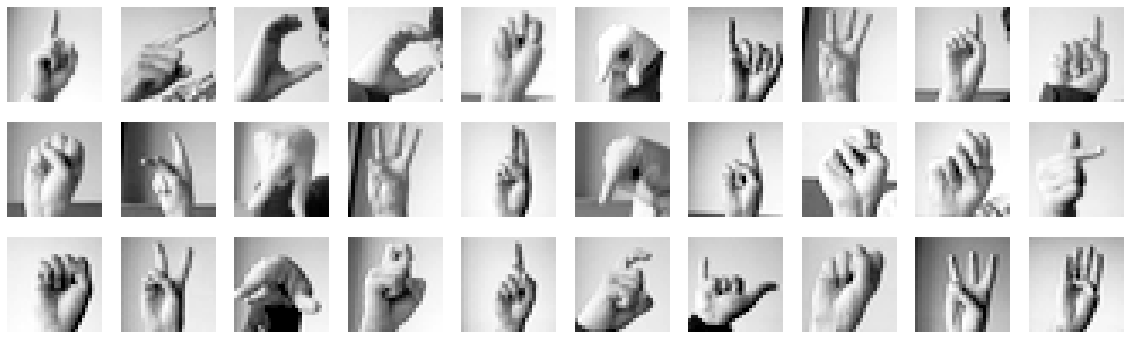

In [29]:
# plot sample images
img_size = 28  
plt.figure(figsize=(20, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    image, label = train_data_ldr.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().reshape(img_size,img_size), cmap="Greys_r")
    plt.axis('off');

Dataset 1 contains 26 classes and they are distributed as follows:

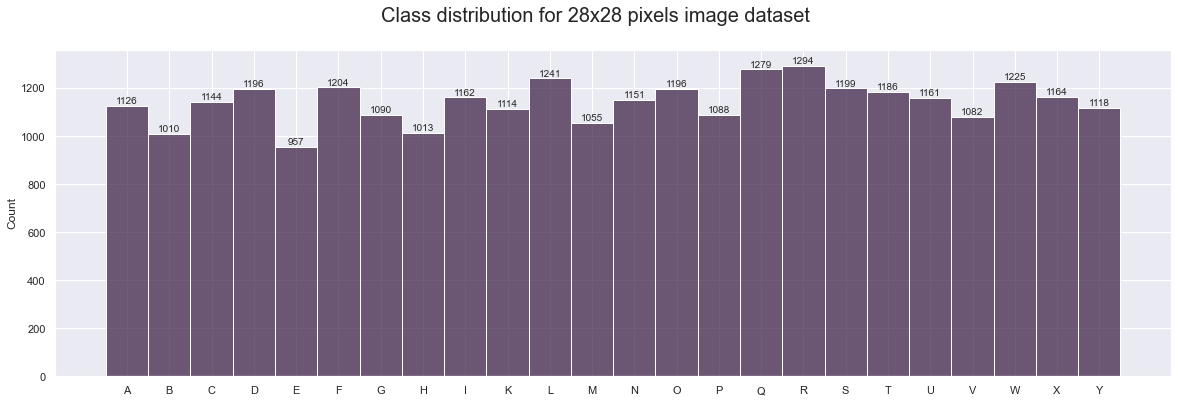

In [30]:
#get class frequency
labels_list = list()
for _, labels in train_data_ldr:
    labels_list= np.concatenate((labels_list,labels))

# replace class numbers with text mask
labels = [alph[x] for x in labels_list]
labels.sort()

# plot class frequency
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Class distribution for 28x28 pixels image dataset', size=20)
plot = sns.histplot(data=labels, alpha=0.7, stat='count')
plot.bar_label(plot.containers[0], size=10);

This is a preview of 64x64 pixels images dataset (converted to 32x32)

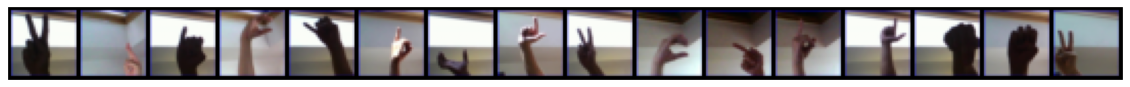

In [31]:
# plot sample images for dataset 2
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = (images * 0.5) + 0.5 # denormalize the dataset
        ax.imshow(make_grid(images, nrow=20).permute(1,2,0))
        break

show_batch(train_data32_ldr)

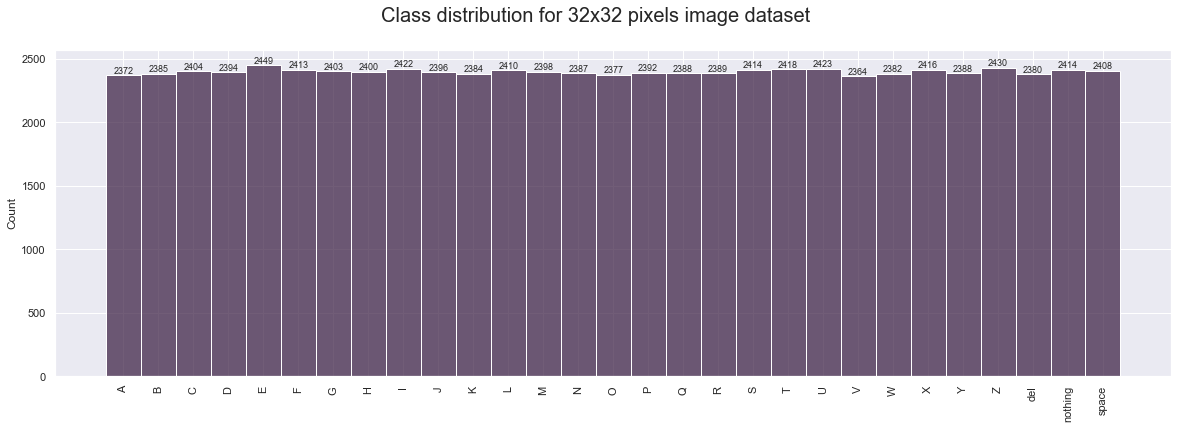

In [32]:
# get class frequency
labels_list = list()
for _, labels in train_data32_ldr:
    labels_list= np.concatenate((labels_list,labels))

# replace class numbers with text mask
labels = [classes[int(x)] for x in labels_list]
labels.sort()

# plot class frequency
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Class distribution for 32x32 pixels image dataset', size=20)
plot = sns.histplot(data=labels, alpha=0.7, stat='count')
plot.bar_label(plot.containers[0], size=9)
plt.setp(plot.get_xticklabels(), rotation=90);

## Simple network case

### Parameters setup
For the simple network scenario, we will apply the following parameters:

<b>Hidden units</b>
While using the 28x28 dataset, since we only have 1 channel, the depth of the 512 hidden units will help us improve the prediction power of the algorithm, previous tests with lower hidden units show less predictive power.

<b>Learning rate</b>
The learning rate parameter will be set in a fixed maner to 0.0001. The training is equipped with the capability to use decreasing learning rate using pytorch exponential learning rate scheduler, but the parameter that sets the decreasing rate (gamma) has been set to 1, so the learning rate will be fixed. In several try outs decreasing the learning rate did not improve our performance.

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html

<b>Batch size</b>
The batch size has been previously setup at the moment the dataloaders were created, but it is important to mention we choose a batch size = 100, this provides good training stability and generalization performance. Smaller batch size have been tested with no better results.

https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [33]:
# Set parameters
channels = 1                            # channels for the images
img_size = 28                           # image height=width
in_size = img_size*img_size*channels    # initial size fed to linear layers
out_size = 26                           # number of classes, also final output of the network
epochs = 10                             # number of epochs to run, kept to 10 to keep exercise computationally feasible
learning_rate = 0.0001                  # learning rate
gamma = 1                               # rate of learning rate decrease per epoch, if gamma=1 learning rate is fixed
n_hidden = 512                          # number of hidden units

### Define network architecture
The simple network architecture scenario will use only 3 fully connected or linear layers together with their corresponding non-linear activation functions (ReLU) and a final softmax layer. 

The layer size of the architecture would be:

Initial size = 1x28x28

- FC1 output = 512  

- FC2 output = 120

- FC3 output = 26

<b>Fully connected / linear layer</b>

<img src="simple_network.png">

In [34]:
# create network arquitecture
# simple NN architecture
class simple(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(simple, self).__init__()
        self.in_size = in_size
        self.n_hidden = n_hidden
        self.out_size = out_size
        self.network = nn.Sequential(
            nn.Linear(self.in_size, self.n_hidden), 
            nn.ReLU(), 
            nn.Linear(self.n_hidden, 256),
            nn.ReLU(), 
            nn.Dropout2d(0.5),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.in_size)
        return self.network(x)

### Instantiate and train/test network model

<b>Optimization algorithm</b>
We will be using the SGD optimization algorithm, which is a simple yet very efficient approach to fitting linear classifiers and it is known to generalize better. 

https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008#:~:text=One%20interesting%20and%20dominant%20argument,results%20in%20improved%20final%20performance.

Below we can see a summary of the created model and the output shapes and parameters at each linear layer

In [35]:
# instantiate model, setup optimizer, print network architecture summary
model_fnn = simple(in_size, n_hidden, out_size)
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(),lr=learning_rate)

summary(model_fnn, input_size = (channels,img_size,img_size), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
         Dropout2d-5                  [-1, 256]               0
            Linear-6                   [-1, 26]           6,682
        LogSoftmax-7                   [-1, 26]               0
Total params: 539,930
Trainable params: 539,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.06
Estimated Total Size (MB): 2.08
----------------------------------------------------------------


So we are now ready to start our training based on the parameters and architecture described earlier

In [36]:
# run train and test tasks and store results
results = pd.DataFrame()

for epoch in range(0, epochs):
    temp = pd.DataFrame()
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    print('Epoch = '+str(epoch)+' Learning Rate = ',optimizer.param_groups[0]["lr"])
    
    train_accuracy, train_loss = train(model_fnn, optimizer, train_data_ldr)
    print('Train set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(train_loss, train_accuracy))
    test_accuracy, test_loss = test(model_fnn, test_data_ldr)
    print('Test set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(test_loss, test_accuracy))
    
    temp['nn'], temp['phase'], temp['epoch'], temp['accuracy'], temp['loss'] = zip(['simple', 'train', epoch, train_accuracy, train_loss])
    results = results.append(temp)
    temp['nn'], temp['phase'], temp['epoch'],  temp['accuracy'], temp['loss'] = zip(['simple', 'test', epoch, test_accuracy, test_loss])
    results = results.append(temp)

    scheduler.step()
    
results = results.reset_index()
results_simple = results.drop('index', axis=1)

Epoch = 0 Learning Rate =  0.0001
Train set: Average loss: 3.1040, Accuracy:(16%)
Test set: Average loss: 2.4139, Accuracy:(31%)
Epoch = 1 Learning Rate =  0.0001
Train set: Average loss: 2.2966, Accuracy:(31%)
Test set: Average loss: 1.8988, Accuracy:(44%)
Epoch = 2 Learning Rate =  0.0001
Train set: Average loss: 1.8753, Accuracy:(42%)
Test set: Average loss: 1.5343, Accuracy:(55%)
Epoch = 3 Learning Rate =  0.0001
Train set: Average loss: 1.5942, Accuracy:(49%)
Test set: Average loss: 1.4167, Accuracy:(55%)
Epoch = 4 Learning Rate =  0.0001
Train set: Average loss: 1.3834, Accuracy:(55%)
Test set: Average loss: 1.2576, Accuracy:(60%)
Epoch = 5 Learning Rate =  0.0001
Train set: Average loss: 1.2098, Accuracy:(61%)
Test set: Average loss: 1.2015, Accuracy:(62%)
Epoch = 6 Learning Rate =  0.0001
Train set: Average loss: 1.0613, Accuracy:(65%)
Test set: Average loss: 1.0819, Accuracy:(66%)
Epoch = 7 Learning Rate =  0.0001
Train set: Average loss: 0.9437, Accuracy:(69%)
Test set: Avera

### Results Simple
The results for the simple network are very encouraging, it reaches a relatively high accuracy and low loss but most importantly it seems to be increasing linearly and could probably be improved by extending the number of epochs. On the negative side, the model overfits a bit after a certain number of epochs. 

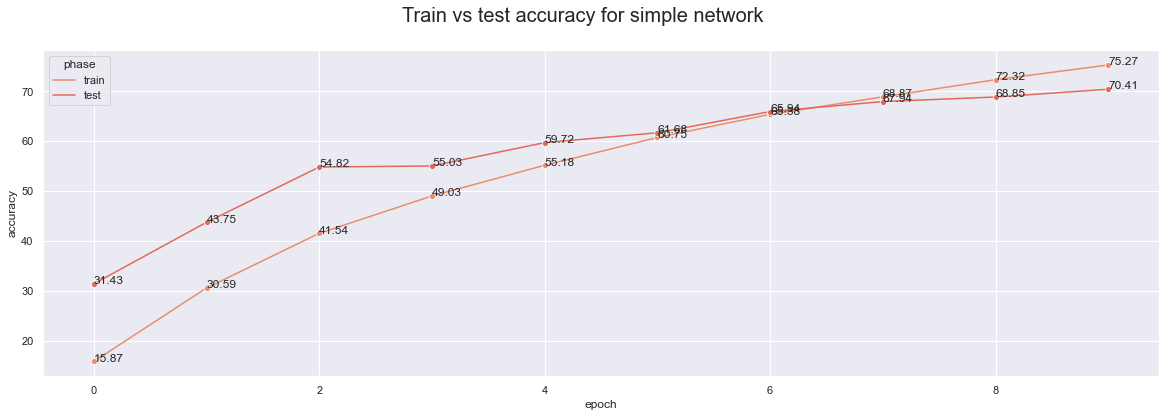

In [37]:
# plot results accuracy
palette = sns.set_palette('flare')
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test accuracy for simple network', size=20)
sns.lineplot(data=results_simple, x='epoch', y='accuracy', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_simple.iterrows():
    ax1.text(item['epoch'],item['accuracy'],f'{item.accuracy:.2f}');


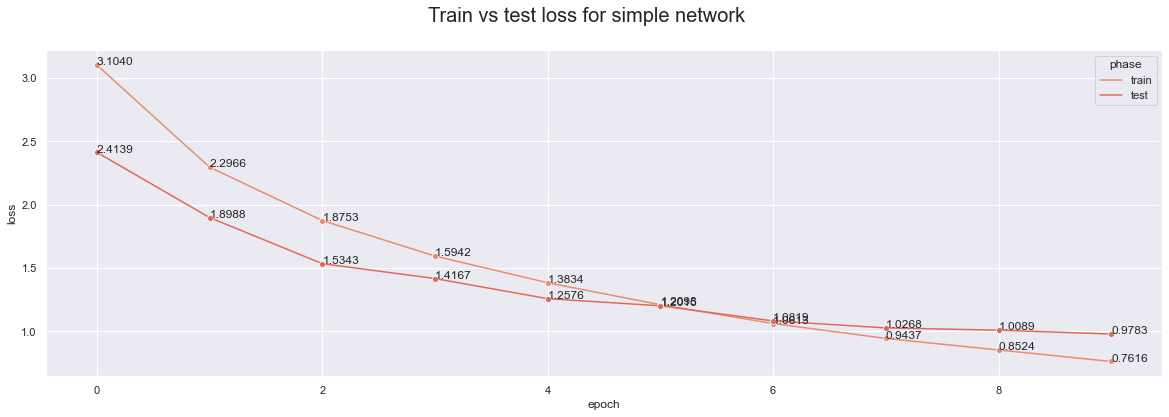

In [38]:
# plot results loss
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test loss for simple network', size=20)
sns.lineplot(data=results_simple, x='epoch', y='loss', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_simple.iterrows():
    ax1.text(item['epoch'],item['loss'],f'{item.loss:.4f}');


## Convolutional network case
### Parameter setup

In [39]:
# set parameters
channels = 1                            # channels for the images
img_size = 28                           # image height=width
in_size = img_size*img_size*channels    # initial size fed to linear layers
out_size = 26                           # number of classes, also final output of the network
epochs = 10                             # number of epochs to run, kept to 10 to keep exercise computationally feasible
learning_rate = 0.0001                  # learning rate
gamma = 0.8                             # rate of learning rate decrease per epoch, if gamma=1 learning rate is fixed
momentum = 0.9                          # momentum
n_hidden = 128                          # number of hidden size (not the same as units)

### Define network architecture
<img src="cnn_network.png">

In [40]:
 # setup CNN architecture
class convolutional1(nn.Module):
    def __init__(self, in_size, n_hidden, out_size):
        super(convolutional1, self).__init__()
        self.conv1 = nn.Conv2d(channels,16,kernel_size = 3)
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3)
        self.conv3 = nn.Conv2d(32,64,kernel_size = 3)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(64*3*3, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 256)
        self.fc3 = nn.Linear(256, out_size)
        
        self.softmax = nn.LogSoftmax(dim=-1)

    def featurizer(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = nn.Flatten()(x)
        return x

    def classifier(self, x):

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.softmax(x)
        return x

    def forward(self,x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
 

### Instantiate and train/test the network model

In [41]:
# instantiate model, setup optimizer, print network architecture summary
model_fnn = convolutional1(in_size, n_hidden, out_size) # convolutional
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(),lr=learning_rate, momentum=momentum)

summary(model_fnn, input_size = (channels,img_size,img_size), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
         MaxPool2d-2           [-1, 16, 13, 13]               0
            Conv2d-3           [-1, 32, 11, 11]           4,640
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Conv2d-5             [-1, 64, 3, 3]          18,496
            Linear-6                  [-1, 128]          73,856
            Linear-7                  [-1, 256]          33,024
         Dropout2d-8                  [-1, 256]               0
            Linear-9                   [-1, 26]           6,682
       LogSoftmax-10                   [-1, 26]               0
Total params: 136,858
Trainable params: 136,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.52
Estimated T

In [42]:
# run train and test tasks and store results
results = pd.DataFrame()

for epoch in range(0, epochs):
    temp = pd.DataFrame()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    print('Epoch = '+str(epoch)+' / Learning Rate = ',optimizer.param_groups[0]["lr"])
    
    train_accuracy, train_loss = train(model_fnn, optimizer, train_data_ldr)
    print('Train set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(train_loss, train_accuracy))
    test_accuracy, test_loss = test(model_fnn, test_data_ldr)
    print('Test set: Average loss: {:.4f}, Accuracy:({:.0f}%)'.format(test_loss, test_accuracy))
    
    temp['nn'], temp['phase'], temp['epoch'], temp['accuracy'], temp['loss'] = zip(['cnn', 'train', epoch, train_accuracy, train_loss])
    results = results.append(temp)
    temp['nn'], temp['phase'], temp['epoch'],  temp['accuracy'], temp['loss'] = zip(['cnn', 'test', epoch, test_accuracy, test_loss])
    results = results.append(temp)
    scheduler.step()
    
results = results.reset_index()
results_cnn = results.drop('index', axis=1)

Epoch = 0 / Learning Rate =  0.0001
Train set: Average loss: 2.7457, Accuracy:(20%)
Test set: Average loss: 1.7220, Accuracy:(48%)
Epoch = 1 / Learning Rate =  8e-05
Train set: Average loss: 1.1811, Accuracy:(62%)
Test set: Average loss: 0.8245, Accuracy:(73%)
Epoch = 2 / Learning Rate =  6.400000000000001e-05
Train set: Average loss: 0.5764, Accuracy:(81%)
Test set: Average loss: 0.5022, Accuracy:(83%)
Epoch = 3 / Learning Rate =  5.120000000000001e-05
Train set: Average loss: 0.3358, Accuracy:(89%)
Test set: Average loss: 0.3973, Accuracy:(87%)
Epoch = 4 / Learning Rate =  4.0960000000000014e-05
Train set: Average loss: 0.2282, Accuracy:(93%)
Test set: Average loss: 0.3741, Accuracy:(88%)
Epoch = 5 / Learning Rate =  3.2768000000000016e-05
Train set: Average loss: 0.1713, Accuracy:(95%)
Test set: Average loss: 0.3471, Accuracy:(89%)
Epoch = 6 / Learning Rate =  2.6214400000000015e-05
Train set: Average loss: 0.1349, Accuracy:(96%)
Test set: Average loss: 0.3386, Accuracy:(90%)
Epoch 

### Results CNN

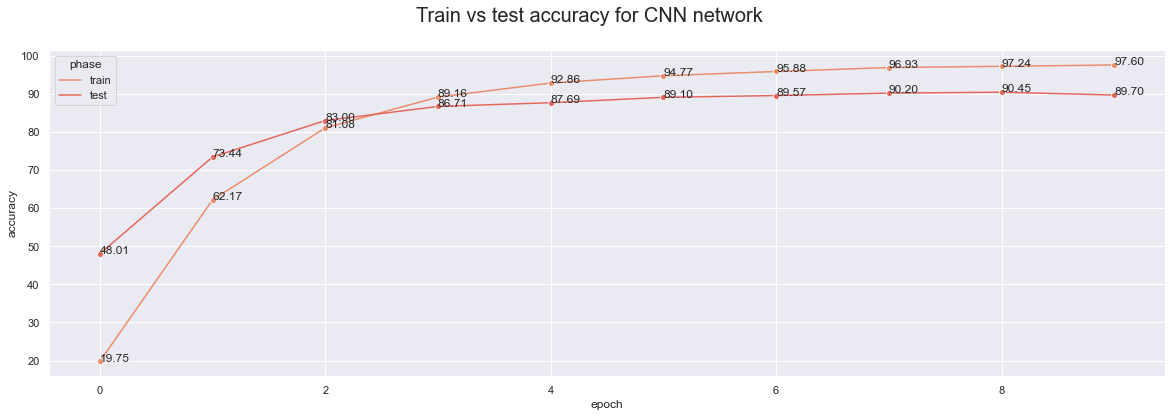

In [43]:
# plot results accuracy
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test accuracy for CNN network', size=20)
sns.lineplot(data=results_cnn, x='epoch', y='accuracy', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_cnn.iterrows():
    ax1.text(item['epoch'],item['accuracy'],f'{item.accuracy:.2f}');

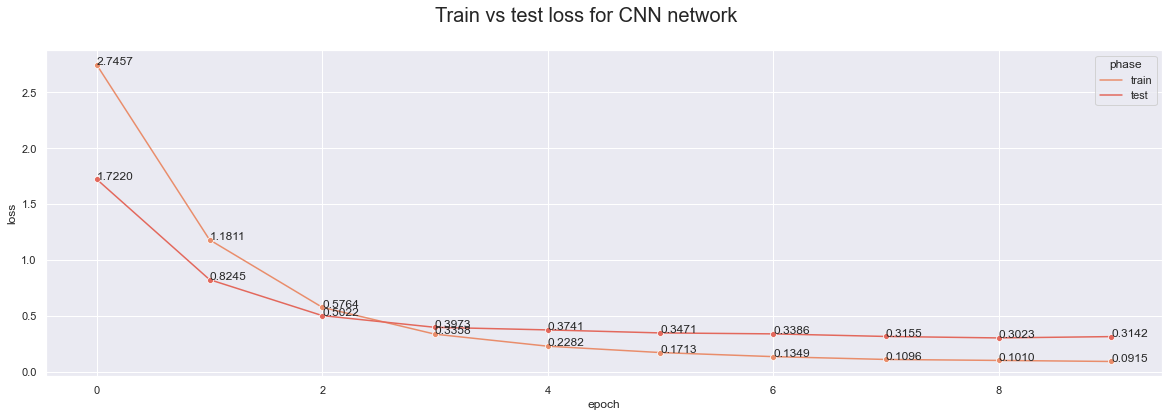

In [44]:
# plot results loss
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Train vs test loss for CNN network', size=20)
sns.lineplot(data=results_cnn, x='epoch', y='loss', hue='phase', marker = 'o', ax=ax1, color='black');

for _,item in results_cnn.iterrows():
    ax1.text(item['epoch'],item['loss'],f'{item.loss:.4f}');

## Summary

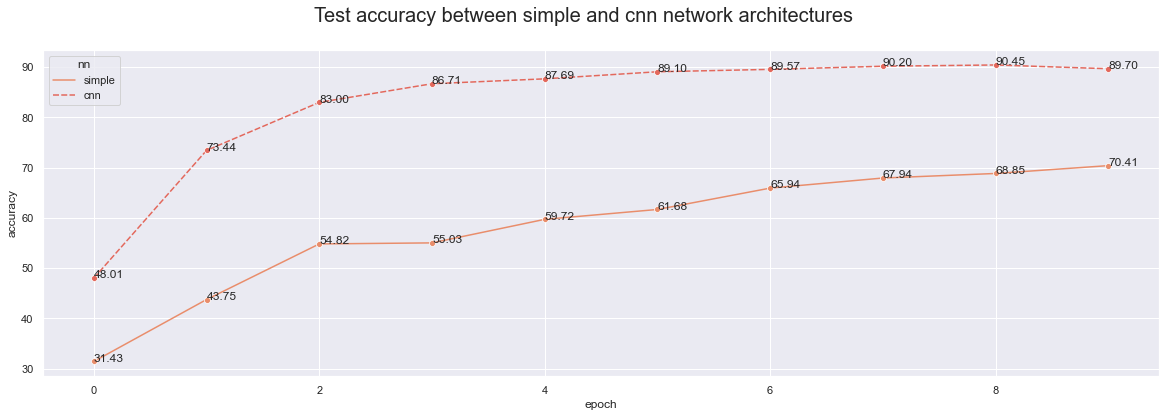

In [45]:
# plot results compare networks accuracy
results_all = pd.concat([results_simple, results_cnn]).reset_index()
results_all = results_all[results_all['phase']=='test']

fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Test accuracy between simple and cnn network architectures', size=20)
sns.lineplot(data=results_all, x='epoch', y='accuracy', hue='nn', style='nn', marker = 'o', ax=ax1, color='black');

for _,item in results_all.groupby('nn'):
    for x,y,m in item[['epoch', 'accuracy','accuracy']].values:
        ax1.text(x,y,f'{m:.2f}')

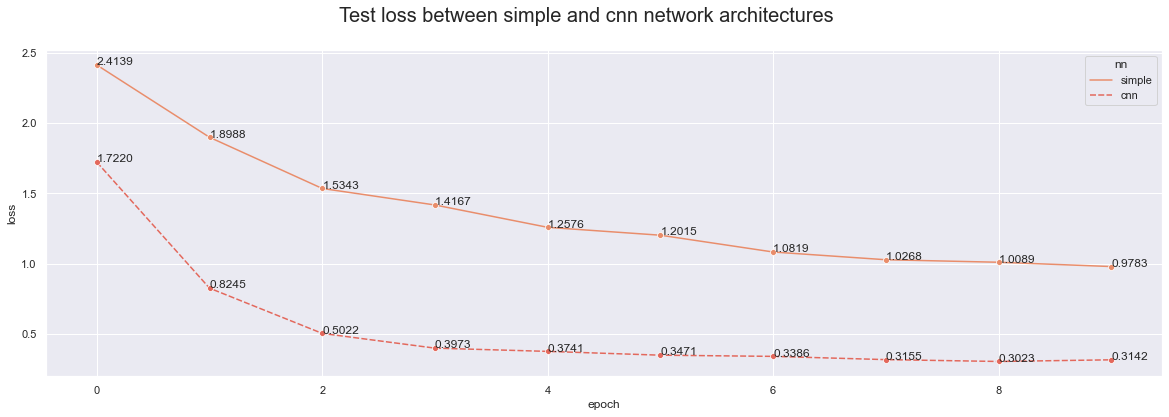

In [46]:
# plot results compare networks loss
fig1, ax1 = plt.subplots(figsize=(20, 6));
fig1.suptitle('Test loss between simple and cnn network architectures', size=20)
sns.lineplot(data=results_all, x='epoch', y='loss', hue='nn', style='nn', marker = 'o', ax=ax1, color='black');

for _,item in results_all.groupby('nn'):
    for x,y,m in item[['epoch', 'loss','loss']].values:
        ax1.text(x,y,f'{m:.4f}')